# Transport equation 1D
***
Created by: Juan Felipe Osorio Ramirez

Department of Applied Mathematics, UW
***

$u_t + c u_x = 0$ with initial condition $u(0,x)= g(x)= e^{-x^2}$.

The analytical solution is given by $u(t,x) = g(x-ct)$.

## Libraries

In [17]:
import sys
sys.path.append('/Users/josorior/Documents/UW/research/kinetick/kinetick/source')

In [18]:
import jax.numpy as np
from jax import grad, jit
from jax.scipy.optimize import minimize

import numpy as np
import matplotlib.pyplot as plt 
#from sklearn.preprocessing import MinMaxScaler
from sklearn.kernel_ridge import KernelRidge
from parameter_learning import *
from plotlib import *
from models import * 
from interpolation import *
from kernels import *
from integrate import trap
from sklearn.metrics import mean_squared_error

import jax.numpy as jnp
from jax import grad, jit
from jax.config import config; 
config.update("jax_enable_x64", True)

from functools import partial # for jit to make codes faster

## Utils

In [19]:
def Kphiphi_assembly(Xomega, Xboundary , h, c, k = 'Gaussian', k_param = 1.):

  # Set kernel to use
  if k == 'Gaussian':
    kernel = Gaussian

  # Size of the square matrix
  Momega = len(Xomega)
  Mboundary = len(Xboundary)
  M = Momega + Mboundary

  # Initialize K(phi,phi)
  Theta = jnp.zeros((M,M))

  # Block 1,1 
  val1 = K(kernel, Xomega, Xomega, k_param)
  val2 = K_dot(kernel, Xomega, Xomega, k_param, 0)
  val3 = val2
  val4 = K_ddot(kernel, Xomega, Xomega, k_param, 0, 1)
  val = val1 + h*c*val2 + h*c*(val3 + h*c*val4)
  Theta = Theta.at[:Momega, :Momega].set(val)

  # Block 1,2
  val1 = K(kernel, Xomega, Xboundary, k_param)
  val2 = K_dot(kernel, Xomega, Xboundary, k_param, 0)
  val = val1 + h*c*val2
  Theta = Theta.at[:Momega, Momega:].set(val)
  Theta = Theta.at[Momega:, :Momega].set(jnp.transpose(val)) # Block 2,1

  # Block 2,2
  val = K(kernel, Xboundary , Xboundary, k_param)
  Theta = Theta.at[Momega:, Momega:].set(val)

  return Theta

In [20]:
def Kphi_assembly(Xtest, Xomega, Xboundary , h, c, k = 'Gaussian', k_param = 1.):

  # Set kernel to use
  if k == 'Gaussian':
    kernel = Gaussian

  # Size of the square matrix
  Momega = len(Xomega)
  Mboundary = len(Xboundary)
  Mtest = len(Xtest)
  M = Momega + Mboundary

  # Initialize K(phi,phi)
  Theta = jnp.zeros((M,Mtest))

  # Block 1
  val1 = K(kernel, Xomega, Xtest, k_param)
  val2 = K_dot(kernel, Xomega, Xtest, k_param, 0)
  val = val1 + h*c*val2
  Theta = Theta.at[:Momega, :].set(val)

  # Block 2
  val = K(kernel, Xboundary , Xtest, k_param)
  Theta = Theta.at[Momega:, :].set(val)


  return Theta

## How far can we go ?

In [35]:
# X_full
Xfull = np.linspace(-5,5,102)
# X_{\partial\Omega}
Xboundary = Xfull[[0,-1]]
# X_\Omega
Xomega = Xfull[1:-1]
# u(X_\Omega,0)
u0 = transport_u0(Xomega)
# kparam
k_param = 0.8
# Wave speed
c = 2
# Time step
h = 0.02

Build `Kphiphi`

In [22]:
Kphiphi = Kphiphi_assembly(Xomega, Xboundary, h, c, k = 'Gaussian', k_param = k_param)

Build `y_prev`

In [23]:
y_prev = jnp.concatenate((u0,np.zeros((len(Xboundary)),)))

Compute $K(\varphi,\varphi)^{-1}y_{\text{prev}}$

In [24]:
R = jnp.diag(jnp.diag(Kphiphi))
sol = jnp.linalg.solve(Kphiphi + 1e-6*R,y_prev)

Get `K(Xtest,Xfull)`

In [25]:
Kphi = Kphi_assembly(Xfull, Xomega, Xboundary , h, c, k = 'Gaussian', k_param = k_param)

In [26]:
u_next = np.dot(Kphi.T,sol)

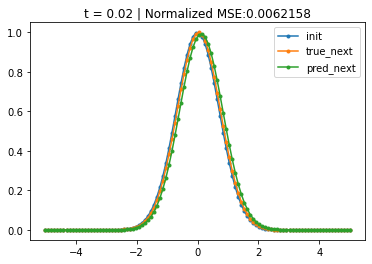

In [27]:
# Initial condition
plt.plot(Xfull,transport_u0(Xfull),'.-',label='init')
# True next
plt.plot(Xfull,transport_sol(Xfull,h,c),'.-',label='true_next')
# Predicted next
plt.plot(Xfull,u_next,'.-',label='pred_next')
# Plot settings
nmse = mean_squared_error(u_next,transport_sol(Xfull,h,c))/mean_squared_error(0*transport_sol(Xfull,h,c),transport_sol(Xfull,h,c))
plt.title('t = {} | Normalized MSE:{}'.format(h, round(nmse,7)))
plt.legend()
plt.show()

## Let's take small steps 

Say we want to get to `t=0.2` by taking `h = 0.01`

In [12]:
t = 0.2
steps = int(t//h)
# Initialize at the initial condition
uprev = u0
for _ in range(steps):
    y_prev = jnp.concatenate((uprev,np.zeros((len(Xboundary)),)))
    sol = jnp.linalg.solve(Kphiphi + 1e-6*R,y_prev)
    u_next = np.dot(Kphi.T,sol)
    # update
    uprev = u_next[1:-1]

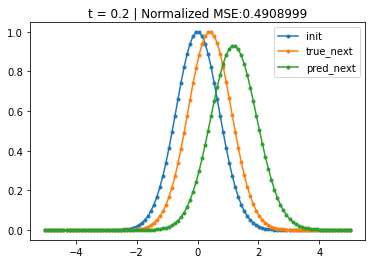

In [13]:
# Initial condition
plt.plot(Xfull,transport_u0(Xfull),'.-',label='init')
# True next
plt.plot(Xfull,transport_sol(Xfull,t,c),'.-',label='true_next')
# Predicted next
plt.plot(Xfull,u_next,'.-',label='pred_next')
# Plot settings
nmse = mean_squared_error(u_next,transport_sol(Xfull,t,c))/mean_squared_error(0*transport_sol(Xfull,t,c),transport_sol(Xfull,t,c))
plt.title('t = {} | Normalized MSE:{}'.format(t, round(nmse,7)))
plt.legend()
plt.show()

## Convergence

In [38]:
mses = []
sup_norms = []
l2_norms = []
L2_norms = []
for n in range(2,11):
    # X_full
    Xfull = np.linspace(-5,5,2**n+2)
    # Delta
    delta = Xfull[1]-Xfull[0]
    # X_{\partial\Omega}
    Xboundary = Xfull[[0,-1]]
    # X_\Omega
    Xomega = Xfull[1:-1]
    # u(X_\Omega,0)
    u0 = transport_u0(Xomega)
    # Kernel parameter
    k_param = 0.8
    # Wave speed
    c = 1
    # Time step
    h = 0.01

    Kphiphi = Kphiphi_assembly(Xomega, Xboundary, h, c, k = 'Gaussian', k_param = k_param)
    y_prev = jnp.concatenate((u0,np.zeros((len(Xboundary)),)))

    R = jnp.diag(jnp.diag(Kphiphi))
    sol = jnp.linalg.solve(Kphiphi + 1e-6*R,y_prev)

    Kphi = Kphi_assembly(Xfull, Xomega, Xboundary , h, c, k = 'Gaussian', k_param = k_param)
    u_next = np.dot(Kphi.T,sol)
    # Vector of differences
    u_true = transport_sol(Xfull,h,c)

    # # True next
    # plt.plot(Xfull,transport_sol(Xfull,t,c),'.-',label='true_next')
    # # Predicted next
    # plt.plot(Xfull,u_next,'.-',label='pred_next')
    # plt.legend()
    # plt.show()
    
    f = np.abs(u_next - u_true)**2
    # sup norm
    #sup_norms.append(f/np.max(ad_sol(Xfull,h,beta,5)))
    # l2 norm
    #l2_norms.append(norm(u_next - ad_sol(Xfull,h,beta,5),ord=2)/norm(ad_sol(Xfull,h,beta,5),ord=2))
    L2_norms.append(trap(f,delta))
    print(trap(f,delta))
    #nmse = mean_squared_error(u_next,ad_sol(Xfull,h,beta,5))/mean_squared_error(0*ad_sol(Xfull,h,beta,5),ad_sol(Xfull,h,beta,5))
    #mses.append(nmse)

0.00014481936965156752
0.0003207559990534545
0.0005005217071976326
0.000500407723906007
0.0005003851487349681
0.0005003849635041838
0.0005003850910309961
0.0005003852551689775
0.0005003853159073794


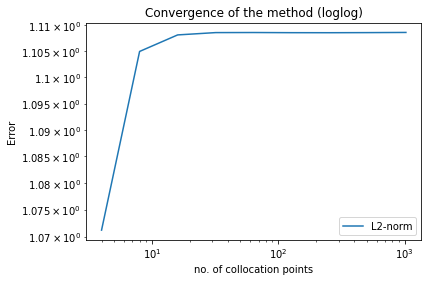

In [29]:
xrange = 2**np.arange(2,11)
#plt.loglog(xrange,sup_norms, label = 'sup-norm')
plt.loglog(xrange,L2_norms,label = 'L2-norm')
#plt.loglog(xrange,mses,label = 'mse')
plt.xlabel('no. of collocation points')
plt.ylabel('Error')
plt.legend()
plt.title('Convergence of the method (loglog)')
plt.show()